In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.models
from keras.layers.convolutional import Conv1D, ZeroPadding1D
from keras.layers.recurrent import Recurrent, LSTM, GRU
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from math import floor, ceil
from sklearn.metrics import accuracy_score
% matplotlib inline

# prepare inputs

In [160]:
def load_and_format_data():
    # load data
    dataset = 'train/1'
    x_data = pd.read_csv(dataset + '.train.calcium.csv')
    y_data = pd.read_csv(dataset + '.train.spikes.csv')
    x_train = x_data['0'].dropna()  # todo: concat these
    y_train = y_data['0'].dropna()
    for i in range(1,8):
        x_train = np.concatenate((x_train,x_data[str(i)].dropna()))
        y_train = np.concatenate((y_train,y_data[str(i)].dropna()))
    x_test = pd.read_csv(dataset + '.train.calcium.csv')['9'].dropna()  # todo: concat these
    y_test = pd.read_csv(dataset + '.train.spikes.csv')['9'].dropna()
    num_y = int(np.max(y_train+1))
    # binarize labels
    lb = LabelBinarizer()
    lb.fit(y_train) # this lb takes 0 -> [1,0,0,0,0], 1-> [0,1,0,0,0], etc.
    y_train = lb.transform(y_train)
#     y_test = lb.transform(y_test)
    # reshape data
    x_train = x_train.reshape((1, len(x_train), 1))
    y_train = y_train.reshape((1, len(y_train), y_train.shape[1]))
    x_test = x_test.values.reshape((1, len(x_test), 1))
#     y_test = y_test.reshape((1, len(y_test), y_test.shape[1]))
    return x_train, y_train, x_test, y_test, num_y
x_train, y_train, x_test, y_test, num_y = load_and_format_data()
print("train, test sizes",x_train.shape,x_test.shape)

train, test sizes (1, 539893, 1) (1, 59717, 1)


# create model

In [161]:
max_features = 10
embedding_dims = 10
kernel_sizes = [21,13,5] # should be odd
pad_sizes = [floor(s/2) for s in kernel_sizes]
model = keras.models.Sequential()
model.add(ZeroPadding1D(padding=pad_sizes[0], input_shape=(None, 1)))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[0], activation="linear"))
model.add(ZeroPadding1D(padding=pad_sizes[1], input_shape=(None, 1)))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[1], activation="linear"))
model.add(ZeroPadding1D(padding=pad_sizes[2], input_shape=(None, 1)))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[2], activation="softmax"))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# fit the model

In [162]:
epochs = 100
model.fit(x_train, y_train, epochs=epochs, verbose=1)

Epoch 1/100
1/1 [==============================] - 1s - loss: 0.1377 - acc: 0.5240
Epoch 2/100
1/1 [==============================] - 0s - loss: 0.1360 - acc: 0.7984
Epoch 3/100
1/1 [==============================] - 0s - loss: 0.1343 - acc: 0.9047
Epoch 4/100
1/1 [==============================] - 0s - loss: 0.1325 - acc: 0.9430
Epoch 5/100
1/1 [==============================] - 0s - loss: 0.1305 - acc: 0.9576
Epoch 6/100
1/1 [==============================] - 0s - loss: 0.1284 - acc: 0.9641
Epoch 7/100
1/1 [==============================] - 0s - loss: 0.1261 - acc: 0.9673
Epoch 8/100
1/1 [==============================] - 0s - loss: 0.1235 - acc: 0.9689
Epoch 9/100
1/1 [==============================] - 0s - loss: 0.1206 - acc: 0.9699
Epoch 10/100
1/1 [==============================] - 0s - loss: 0.1174 - acc: 0.9705
Epoch 11/100
1/1 [==============================] - 0s - loss: 0.1139 - acc: 0.9709
Epoch 12/100
1/1 [==============================] - 0s - loss: 0.1099 - acc: 0.9712
E

# evaluate

----------training----------
pred nonzeros	 0.0211838271658
acc		 0.973672561045
corr		 -0.00961301057692
----------testing----------
pred nonzeros	 0.0168628698696
acc		 0.981697004203
corr		 -0.00715480523803


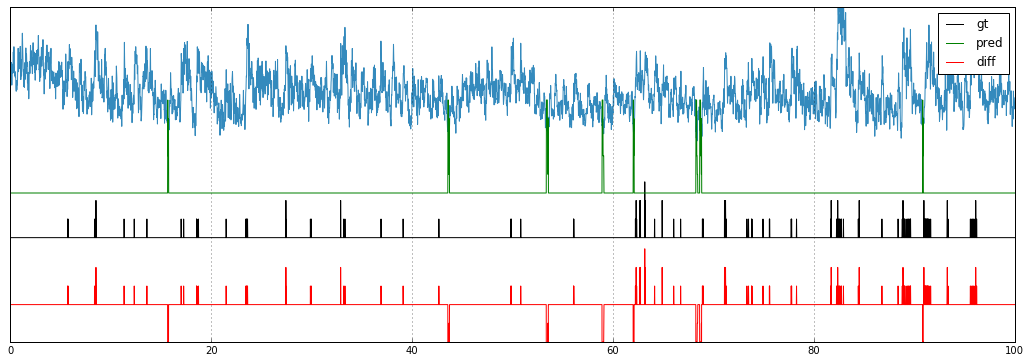

In [173]:
def visualize(calcium, spikes, spikes2=np.zeros(1)):
    t = np.arange(len(calcium)) / 100.0
    plt.figure(figsize=(18, 6))
    plt.hold(True)
    plt.plot(t, calcium, color='#348ABD')
    plt.plot(t, spikes / 2.0 - 3.2, color='black',label='gt')
    if not np.sum(spikes)==0:
        plt.plot(t, spikes2 / 2.0 - 2, color='g',label='pred')
        plt.plot(t, (spikes-spikes2) / 2.0 - 5, color='r',label='diff')
    plt.yticks([])
    plt.ylim([-6, 3])
    plt.xlim([0,100])
    plt.grid()
    plt.legend()
    plt.show()

print('----------training----------')
y_pred = np.argmax(model.predict(x_train)[0,:,:],axis=1)
print('pred nonzeros\t',str(np.sum(y_pred) / y_pred.size))
print("acc\t\t",accuracy_score(y_pred,np.argmax(y_train[0,:,:],axis=1)))
print("corr\t\t",np.corrcoef(y_pred,np.argmax(y_train[0,:,:],axis=1))[0,1])

print('----------testing----------')
y_pred = np.argmax(model.predict(x_test)[0,:,:],axis=1)
print('pred nonzeros\t',str(np.sum(y_pred) / y_pred.size))
print("acc\t\t",accuracy_score(y_pred,y_test))
print("corr\t\t",np.corrcoef(y_pred,y_test)[0,1])
visualize(x_test[0,:,0],y_test,y_pred)